In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize


In [ ]:
# Read data from Excel file
df = pd.read_excel("covid19.xlsx")

Part A

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df['Days'] = (df['Date'] - df['Date'].min()).dt.days

In [ ]:
# SIR model equations
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]
# Objective function for optimization
def objective(params, *args):
    beta, gamma = params
    y0, t, observed = args
    solution = odeint(sir_model, y0, t, args=(beta, gamma)) #odient is used for solving the differential
    predicted = solution[:, 1]
    return np.sum((predicted - observed) ** 2)

In [ ]:
N = 1400000000

In [ ]:
new_df = pd.DataFrame({
    'Date': df['Date'],
    'I': df['Active Cases'],
    'R': df['Cured/Discharged'] + df['Death']
})
new_df['S'] = N - (df['Active Cases'] + df['Cured/Discharged'] + df['Death'])
print(new_df)

          Date        I         R           S
0   2020-03-01        0         3  1399999997
1   2020-03-02        2         3  1399999995
2   2020-03-03        3         3  1399999994
3   2020-03-04       25         3  1399999972
4   2020-03-05       27         3  1399999970
..         ...      ...       ...         ...
816 2022-05-26  3710525  43297397  1352992078
817 2022-05-27  3715221  43312626  1352972153
818 2022-05-28  3723446  43322139  1352954415
819 2022-05-29  3736648  43333760  1352929592
820 2022-05-30  3745237  43347609  1352907154

[821 rows x 4 columns]


In [ ]:
start_date = pd.to_datetime('2020-07-16')
end_date = pd.to_datetime('2021-01-31')
df1 = new_df[(new_df['Date'] >= start_date) & (new_df['Date'] <= end_date)].copy()

start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2021-05-31')
df2 = new_df[(new_df['Date'] >= start_date) & (new_df['Date'] <= end_date)].copy()

start_date = pd.to_datetime('2022-01-01')
end_date = pd.to_datetime('2022-03-31')
df3 = new_df[(new_df['Date'] >= start_date) & (new_df['Date'] <= end_date)].copy()


df_list = [df1, df2, df3]

In [ ]:
k = 1
for df_temp in df_list:
    t = np.arange(len(df_temp))
    initial_infected = df_temp.iloc[1][1]
    y0 = [N - initial_infected, initial_infected, 0]

    # Initial parameter guess
    initial_guess = [2.0, 0.1]

    # Optimization
    result = minimize(objective, initial_guess, args=(y0, t, df_temp["I"]), method='L-BFGS-B')
    estimated_params = result.x
    R0, gamma = estimated_params

    # Report results
    print(f"{k} Wave")
    print(f"Estimated R0: {R0}")
    print(f"Estimated gamma: {gamma}")
    print(f"----------------------------------------------")
    k=k+1

1 Wave
Estimated R0: 1.1105974932779796
Estimated gamma: 1.0951351687171726
----------------------------------------------
2 Wave
Estimated R0: -0.018893712019403815
Estimated gamma: -0.024015918071159183
----------------------------------------------
3 Wave
Estimated R0: 1.7067975330151783
Estimated gamma: 1.6660444303345276
----------------------------------------------


Part B

In [ ]:
data = new_df[['Date', 'I', 'R']].copy()
data['Date'] = pd.to_datetime(data['Date'])
data['Days'] = (data['Date'] - data['Date'].min()).dt.days
data = data[['Days', 'I', 'R']].values

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[:, 1:])
X, y = [], []
for i in range(len(data_scaled)):
    end_ix = i + 6
    if end_ix < len(data_scaled):
        seq_x, seq_y = data_scaled[i:end_ix, :], data_scaled[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)

X, y = np.array(X), np.array(y)

In [ ]:
# Split
train_size = 20 * 30  # 30 days in a month
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]


In [ ]:
# Build LSTM model
model = Sequential()
model.add(InputLayer((6,2)))
model.add(LSTM(units=70))
model.add(Dense(units=2))  # Two outputs for 'Infected' and 'Recovered'
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=35, batch_size=64)

Epoch 1/35
10/10 [==============================] - 2s 3ms/step - loss: 0.0573
Epoch 2/35
10/10 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 3/35
10/10 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 4/35
10/10 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 5/35
10/10 [==============================] - 0s 3ms/step - loss: 9.4622e-04
Epoch 6/35
10/10 [==============================] - 0s 4ms/step - loss: 3.6360e-04
Epoch 7/35
10/10 [==============================] - 0s 4ms/step - loss: 2.1614e-04
Epoch 8/35
10/10 [==============================] - 0s 4ms/step - loss: 2.0084e-04
Epoch 9/35
10/10 [==============================] - 0s 3ms/step - loss: 1.7243e-04
Epoch 10/35
10/10 [==============================] - 0s 4ms/step - loss: 1.5805e-04
Epoch 11/35
10/10 [==============================] - 0s 3ms/step - loss: 1.5085e-04
Epoch 12/35
10/10 [==============================] - 0s 3ms/step - loss: 1.4421e-04
Epoch 13/35
10/10

In [ ]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

7/7 [==============================] - 0s 2ms/step
Mean Squared Error: 0.07298418701557674


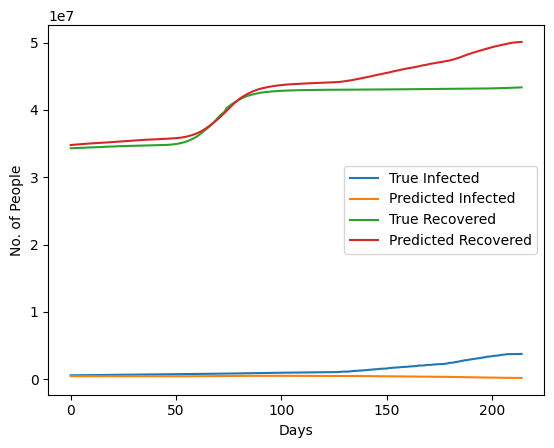

In [ ]:
# Plot the results
plt.plot(y_test_inv[:, 0], label='True Infected')
plt.plot(y_pred_inv[:, 0], label='Predicted Infected')
plt.plot(y_test_inv[:, 1], label='True Recovered')
plt.plot(y_pred_inv[:, 1], label='Predicted Recovered')
plt.xlabel("Days")
plt.ylabel("No. of People")
plt.legend()
plt.show()

Part C

In [ ]:
# Define a range of nodes to try
nodes_list = [10, 20, 40, 50, 60, 80, 100, 120, 140, 150]

best_mse = float('inf')
best_nodes = None

# Perform a grid search over different numbers of nodes
for nodes in nodes_list:
    model = Sequential()
    model.add(InputLayer((6,2)))
    model.add(LSTM(units=nodes))
    model.add(Dense(units=2))  # Two outputs for 'Infected' and 'Recovered'
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=35, batch_size=64, verbose=0)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Inverse transform the predictions and true values
    y_pred_inv = scaler.inverse_transform(y_pred)
    # y_test_inv = scaler.inverse_transform(y_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test_inv, y_pred_inv)

    # Update the best model if needed
    if mse < best_mse:
        best_mse = mse
        best_nodes = nodes

    print(f'Nodes: {nodes}, Mean Squared Error: {mse}')

print(f'Optimal number of nodes: {best_nodes}')
print(f'Best Mean Squared Error on Test Set: {best_mse}')

7/7 [==============================] - 0s 2ms/step
Nodes: 10, Mean Squared Error: 4140372764933.9565
7/7 [==============================] - 0s 2ms/step
Nodes: 20, Mean Squared Error: 11037528655097.725
7/7 [==============================] - 0s 2ms/step
Nodes: 40, Mean Squared Error: 9410711422372.629
7/7 [==============================] - 0s 2ms/step
Nodes: 50, Mean Squared Error: 26122641366518.89
7/7 [==============================] - 0s 2ms/step
Nodes: 60, Mean Squared Error: 2428095487387.5728
7/7 [==============================] - 0s 2ms/step
Nodes: 80, Mean Squared Error: 4578285603319.539
7/7 [==============================] - 0s 2ms/step
Nodes: 100, Mean Squared Error: 3896807548375.802
7/7 [==============================] - 0s 3ms/step
Nodes: 120, Mean Squared Error: 6004444862091.316
7/7 [==============================] - 1s 4ms/step
Nodes: 140, Mean Squared Error: 4968444290776.548
7/7 [==============================] - 0s 3ms/step
Nodes: 150, Mean Squared Error: 41556343668

Part D



In [ ]:
last_date = pd.to_datetime(new_df['Date'].max(), format='%Y-%m-%d')
future_dates = [last_date + pd.DateOffset(days=i) for i in range(1, 2 * 365 + 1)]

In [ ]:
last_observed = []
for i in range (815,816):
    lx = []
    lx = data_scaled[i:i+6,:]
    last_observed.append(lx)

last_observed = np.array(last_observed)

In [ ]:
# Build LSTM model
model1 = Sequential()
model1.add(InputLayer((6,2)))
model1.add(LSTM(units=70))
model1.add(Dense(units=2))  # Two outputs for 'Infected' and 'Recovered'
model1.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model1.fit(X_train, y_train, epochs=35, batch_size=64)

Epoch 1/35
10/10 [==============================] - 2s 4ms/step - loss: 0.0506
Epoch 2/35
10/10 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 3/35
10/10 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 4/35
10/10 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 5/35
10/10 [==============================] - 0s 4ms/step - loss: 6.0291e-04
Epoch 6/35
10/10 [==============================] - 0s 3ms/step - loss: 2.4005e-04
Epoch 7/35
10/10 [==============================] - 0s 4ms/step - loss: 1.7748e-04
Epoch 8/35
10/10 [==============================] - 0s 4ms/step - loss: 1.4856e-04
Epoch 9/35
10/10 [==============================] - 0s 3ms/step - loss: 1.2682e-04
Epoch 10/35
10/10 [==============================] - 0s 3ms/step - loss: 1.1730e-04
Epoch 11/35
10/10 [==============================] - 0s 4ms/step - loss: 1.1314e-04
Epoch 12/35
10/10 [==============================] - 0s 4ms/step - loss: 1.0849e-04
Epoch 13/35
10/10

In [ ]:
last_observed = []
for i in range (815,816):
    lx = []
    lx = data_scaled[i:i+6,:]
    last_observed.append(lx)

last_observed = np.array(last_observed)

In [ ]:
forecast = []
for i in range (730):
    y_temp = model1.predict(last_observed)
    next_data_point_inv = scaler.inverse_transform(y_temp)
    forecast.append(next_data_point_inv.flatten())

    for j in range (5):
        last_observed[0][j] = last_observed[0][j+1]
    last_observed[0][5] = y_temp

forecast_df = pd.DataFrame(forecast, columns=['Infected', 'Recovered'], index=future_dates)

1/1 [==============================] - 0s 15ms/step


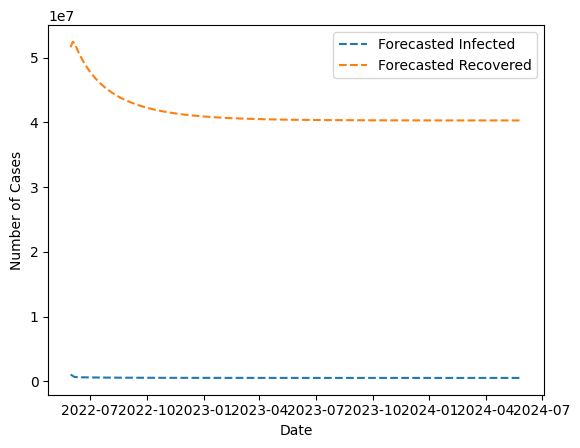

In [ ]:
plt.plot(forecast_df.index, forecast_df['Infected'], label='Forecasted Infected', linestyle='dashed')
plt.plot(forecast_df.index, forecast_df['Recovered'], label='Forecasted Recovered', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()